<a href="https://colab.research.google.com/github/yourfriendjacob/js-spring-cs5567/blob/main/cifar10_ccn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.saving import *
from sklearn.metrics import accuracy_score
from google.colab import drive
import time
import imageio

In [2]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

fatal: destination path 'IMagenet' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


Tiny img net ONLY

In [2]:
drive.mount( '/content/drive', force_remount=True )
path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)



tiny_img_net = get_id_dictionary()
# (X_train, Y_train), (X_test,Y_test) = cifar10.get_data()
X_train, Y_train, x_test, y_test = get_data(tiny_img_net)

def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]



x_train, y_train = shuffle_data(X_train, Y_train)


Mounted at /content/drive
starting loading data


<ipython-input-2-26eacac8aded>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
<ipython-input-2-26eacac8aded>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))


finished loading data, in 79.34778499603271 seconds


In [ ]:
y_train = to_categorical(y_train, 200)
y_val = to_categorical(y_val, 200)

Load data to train

In [2]:
num_classes = 100

cifar10 = tf.keras.datasets.cifar10.load_data()
cifar100 = tf.keras.datasets.cifar100.load_data()
(X_train, Y_train), (X_test,Y_test) = cifar100

x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

y_train = to_categorical(y_train, num_classes = num_classes)
y_val = to_categorical(y_val, num_classes = num_classes)
y_test = to_categorical(Y_test, num_classes = num_classes)




169001437/169001437 [==============================] - 3s 0us/step


In [ ]:
x_train = x_train * 1.0/255

x_val = x_val * 1.0/255

X_test = X_test * 1.0/255

train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)

In [3]:
print(f'x train shape: {x_train.shape}')
print(f'y train shape: {y_train.shape}')

x train shape: (100000, 64, 64, 3)
y train shape: (100000, 200)


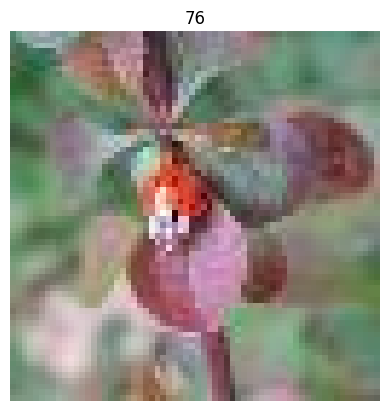

In [19]:
index = 20

test_image = x_train[index]
test_label = np.argmax(y_train[index])
plt.imshow(test_image)
plt.title(test_label)
plt.axis('off')
plt.show()

Callback func

In [4]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

Import trained model

In [5]:
filename = '/a_83.keras'
base_model = load_model(filename)

model = tf.keras.models.Sequential()
for layer in base_model.layers[1:-1]:
  model.add(layer)

for layer in model.layers:
  layer.trainable = False

model.add(Dropout(.5, name='output_dropout'))
model.add(Dense(200, activation='softmax', name='output'))


optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'accuracy'])

# model.summary()


start model from the beginning

In [ ]:



model = tf.keras.models.Sequential()
model.add(UpSampling2D(size = (2, 2), interpolation='bilinear'))
model.add(Conv2D(filters = 512, kernel_size= (9, 9), activation = 'relu', input_shape = (64, 64, 3)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu')) #input 28,28 output 26,26
model.add(Dropout(0.5))
model.add(MaxPooling2D(2, 2)) #output 13,13
model.add(Conv2D(filters = 512, kernel_size = (4, 4), activation = 'relu')) #output 10,10
model.add(MaxPooling2D(2, 2)) #output 5,5
model.add(Dropout(0.5))
model.add(Conv2D(filters = 512, kernel_size = (2, 2), activation = 'relu'))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=.9, nesterov=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'accuracy'])



In [7]:
result = model.fit(
    x_train, y_train,
    batch_size = 64,
    validation_data = (x_test, y_test),
    epochs = 20,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/20
1563/1563 [==============================] - 40s 25ms/step - loss: 26730.0098 - categorical_accuracy: 0.0644 - accuracy: 0.0644 - val_loss: 5996.5039 - val_categorical_accuracy: 0.0873 - val_accuracy: 0.0873 - lr: 4.3200e-04
Epoch 2/20
1563/1563 [==============================] - 39s 25ms/step - loss: 25359.3516 - categorical_accuracy: 0.0609 - accuracy: 0.0609 - val_loss: 5740.1992 - val_categorical_accuracy: 0.0847 - val_accuracy: 0.0847 - lr: 4.3200e-04
Epoch 3/20
1563/1563 [==============================] - 39s 25ms/step - loss: 24591.1699 - categorical_accuracy: 0.0585 - accuracy: 0.0585 - val_loss: 5563.2466 - val_categorical_accuracy: 0.0902 - val_accuracy: 0.0902 - lr: 4.3200e-04
Epoch 4/20
1563/1563 [==============================] - 39s 25ms/step - loss: 24093.8828 - categorical_accuracy: 0.0576 - accuracy: 0.0576 - val_loss: 5312.3281 - val_categorical_accuracy: 0.0888 - val_accuracy: 0.0888 - lr: 4.3200e-04
Epoch 5/20
1563/1563 [==============================] - 

KeyboardInterrupt: 

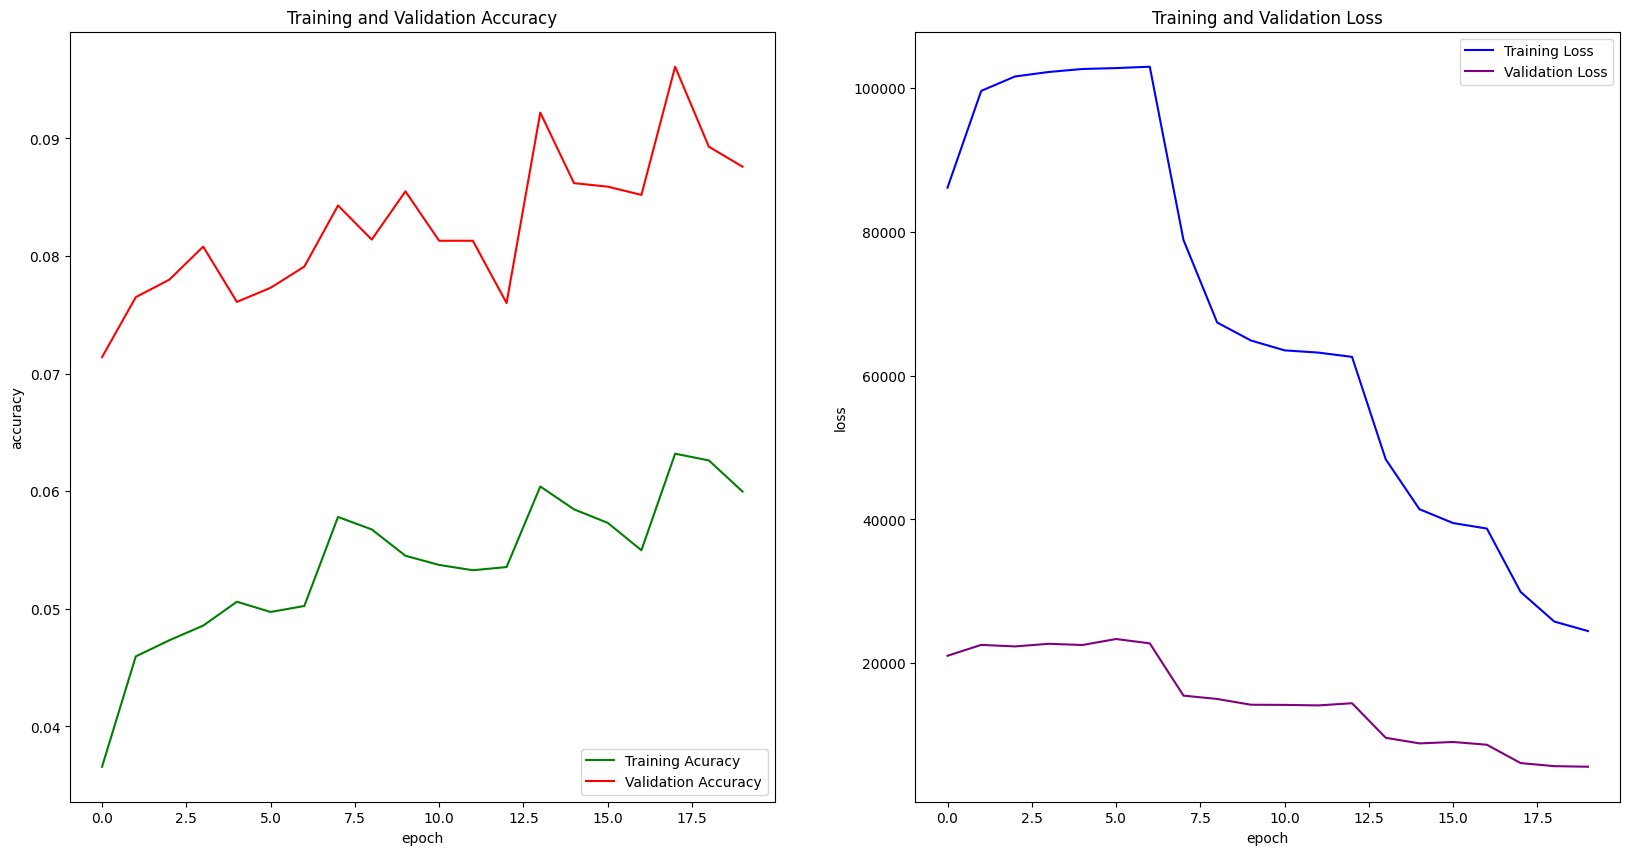

In [6]:
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()


plot_acc_loss(result)

In [12]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape, X_test.shape)
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

313/313 [==============================] - 8s 26ms/step
(10000,) (2000000,) (10000, 64, 64, 3)


InvalidParameterError: The 'y_true' parameter of accuracy_score must be an array-like or a sparse matrix. Got 0 instead.

In [14]:
model.summary(show_trainable=True)

Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 up_sampling2d_1 (UpSamplin  (None, 64, 64, 3)         0         N          
 g2D)                                                                       
                                                                            
 conv2d_4 (Conv2D)           (None, 56, 56, 512)       124928    N          
                                                                            
 dropout_3 (Dropout)         (None, 56, 56, 512)       0         N          
                                                                            
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 512)       0         N          
 g2D)                                                                       
                                                                            
 conv2d_5 (Conv2D)           (None, 26, 26, 512)      

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(result.history)
hist_csv_file = '/a_83.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

model.save('/a_83.keras')